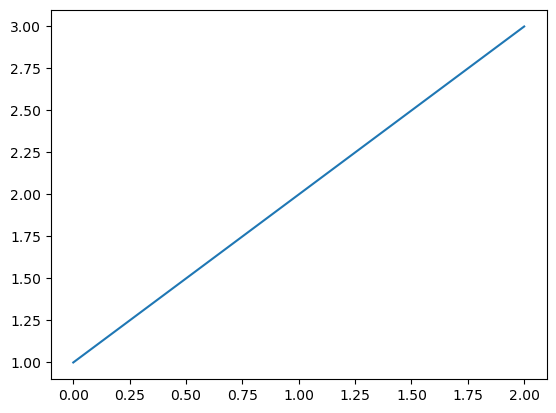

In [1]:
import matplotlib.pyplot as plt
plt.plot([1,2,3])

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, AdamW
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transform
import torchvision.datasets as datasets
from torchvision.utils import make_grid

In [4]:
transforms = transform.Compose(
        [
            transform.ToTensor(),
            transform.Resize((32, 32), 
                      interpolation=transform.InterpolationMode.BICUBIC, 
                      antialias=True),
            transform.RandomHorizontalFlip(),
            transform.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
        ])

In [5]:
dataset = datasets.Flowers102(root="data", download=True, transform=transforms)

In [6]:
dataloader = DataLoader(dataset, batch_size=64, 
                        pin_memory=False, 
                        num_workers=0, 
                        shuffle=True
                           )

In [8]:
def inverse_transform(tensors):
    """Convert tensors from [-1., 1.] to [0., 255.]"""
    return ((tensors.clamp(-1, 1) + 1.0) / 2.0) * 255.0 

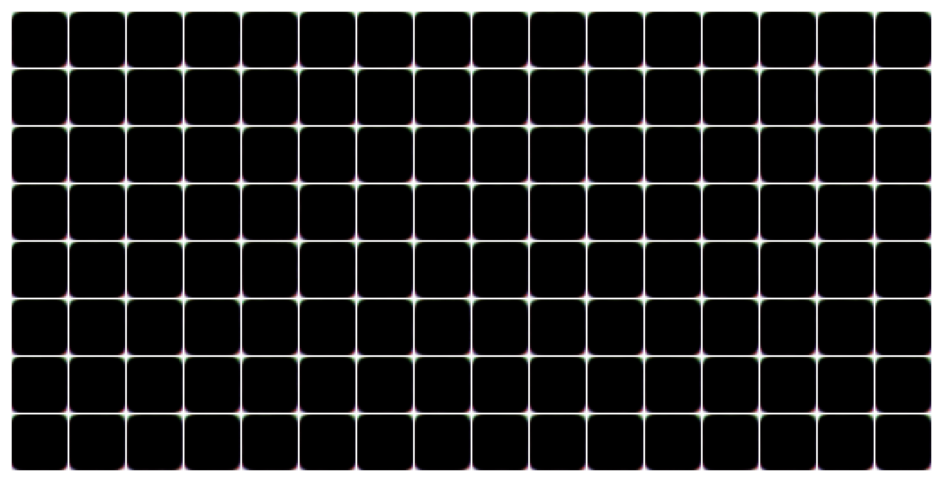

In [149]:
plt.figure(figsize=(12, 6), facecolor='white')

for b_image, _ in dataloader:
    b_image = conv_vae(b_image.cuda())[0]
    b_image = inverse_transform(b_image).cpu()
    grid_img = make_grid(b_image / 255.0, nrow=16, padding=True, pad_value=1, normalize=True)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis("off")
    break

In [10]:
x = next(iter(dataloader))

In [117]:
x[0]

tensor([[[-0.4211, -0.4662, -0.6269,  ..., -0.8010, -0.8071, -0.7725],
         [-0.5580, -0.6051, -0.6897,  ..., -0.8178, -0.7756, -0.7432],
         [-0.6461, -0.6679, -0.7237,  ..., -0.7899, -0.7384, -0.7415],
         ...,
         [-0.7562, -0.6726, -0.7069,  ..., -0.8340, -0.7813, -0.5938],
         [-0.7956, -0.6803, -0.7019,  ..., -0.7458, -0.6463, -0.6822],
         [-0.7907, -0.6892, -0.7120,  ..., -0.6934, -0.5875, -0.4649]],

        [[-0.3992, -0.4264, -0.6027,  ..., -0.7981, -0.8076, -0.7726],
         [-0.5351, -0.5656, -0.6531,  ..., -0.8143, -0.7751, -0.7428],
         [-0.6088, -0.6286, -0.6855,  ..., -0.7747, -0.7242, -0.7344],
         ...,
         [-0.7449, -0.6497, -0.6682,  ..., -0.8191, -0.7590, -0.6153],
         [-0.7919, -0.6654, -0.6749,  ..., -0.7331, -0.6469, -0.6685],
         [-0.7841, -0.6735, -0.6967,  ..., -0.6721, -0.5934, -0.5307]],

        [[-0.4249, -0.4644, -0.6449,  ..., -0.8152, -0.8234, -0.7812],
         [-0.5714, -0.5982, -0.6952,  ..., -0

In [98]:
class Encoder(nn.Module):
    def __init__(self, imgChannels=3, featureDim=32*24*24, zDim=256):
        super().__init__()
        
        self.feature_dim = featureDim

        self.Conv1 = nn.Conv2d(imgChannels, 16, 5)
        self.Conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(featureDim, zDim)
        self.fc2 = nn.Linear(featureDim, zDim)
        
    def forward(self,x):
        x = F.relu(self.Conv1(x))
        x = F.relu(self.Conv2(x))
        x = x.reshape(-1, self.feature_dim)
        mu = self.fc1(x)
        logVar = self.fc2(x)
        return mu, logVar

In [150]:
class Decoder(nn.Module):
    def __init__(self,zDim,featureDim,):
        super().__init__()
        self.fc1 = nn.Linear(zDim, featureDim)
        self.Conv1 = nn.ConvTranspose2d(32, 16, 5)
        self.Conv2 = nn.ConvTranspose2d(16, 3, 5)
        
    def forward(self,z):
        z = F.relu(self.fc1(z))
        z = z.reshape(-1, 32, 24, 24)
        z = F.relu(self.Conv1(z))
        x = F.tanh(self.Conv2(z))
        
        return x
    

In [99]:
enc = Encoder()

In [118]:
enc(x[0])

(tensor([[-0.0192, -0.0213, -0.0148,  ..., -0.0288, -0.0396, -0.0247],
         [-0.0136,  0.0139,  0.0126,  ...,  0.0029, -0.0049, -0.0963],
         [-0.0204, -0.0204, -0.0017,  ..., -0.0340, -0.0001, -0.0466],
         ...,
         [-0.0367, -0.0085, -0.0063,  ...,  0.0085, -0.0288, -0.0338],
         [-0.0567,  0.0144,  0.0148,  ..., -0.0156, -0.0613, -0.0169],
         [ 0.0146, -0.0146,  0.0221,  ..., -0.0425, -0.0305, -0.0482]],
        grad_fn=<AddmmBackward0>),
 tensor([[ 0.0366,  0.0512, -0.0411,  ..., -0.0086,  0.0358, -0.0626],
         [-0.0011, -0.0278, -0.0052,  ...,  0.0167, -0.0148, -0.0502],
         [ 0.0515, -0.0150, -0.0160,  ..., -0.0368, -0.0463, -0.0528],
         ...,
         [ 0.0556, -0.0224, -0.0170,  ..., -0.0032, -0.0363,  0.0088],
         [ 0.0350,  0.0051, -0.0747,  ..., -0.0541, -0.0222, -0.0395],
         [ 0.0485,  0.0566, -0.0882,  ..., -0.1075, -0.0916, -0.1754]],
        grad_fn=<AddmmBackward0>))

In [157]:
e = torch.randn(64,256)

In [158]:
z = enc(x[0])[0] + torch.exp(enc(x[0])[1]/2)*e

In [159]:
dec = Decoder(256,32*24*24)

In [172]:
z.shape

torch.Size([64, 256])

In [161]:
x = dec(z)

In [165]:
(inverse_transform(x[0])/255.).cpu()

tensor([[[0.5164, 0.5214, 0.5292,  ..., 0.5424, 0.5254, 0.5346],
         [0.5199, 0.5260, 0.5307,  ..., 0.5344, 0.5266, 0.5397],
         [0.5102, 0.5129, 0.5138,  ..., 0.5179, 0.5664, 0.5250],
         ...,
         [0.5191, 0.4682, 0.5125,  ..., 0.5097, 0.4981, 0.5165],
         [0.5174, 0.5197, 0.5453,  ..., 0.5156, 0.4993, 0.5080],
         [0.5037, 0.5049, 0.5226,  ..., 0.5158, 0.5012, 0.5122]],

        [[0.4946, 0.4914, 0.4835,  ..., 0.4620, 0.4722, 0.4969],
         [0.4918, 0.4674, 0.4485,  ..., 0.4890, 0.4973, 0.5121],
         [0.5042, 0.4894, 0.4380,  ..., 0.4377, 0.4673, 0.4876],
         ...,
         [0.4924, 0.5215, 0.4773,  ..., 0.4989, 0.4939, 0.4694],
         [0.4947, 0.5020, 0.5335,  ..., 0.4638, 0.5326, 0.4964],
         [0.4975, 0.4940, 0.5016,  ..., 0.4969, 0.4915, 0.4938]],

        [[0.4682, 0.4737, 0.4749,  ..., 0.4779, 0.4731, 0.4619],
         [0.4678, 0.4926, 0.4842,  ..., 0.4682, 0.4557, 0.4686],
         [0.4732, 0.5222, 0.4908,  ..., 0.4170, 0.5025, 0.

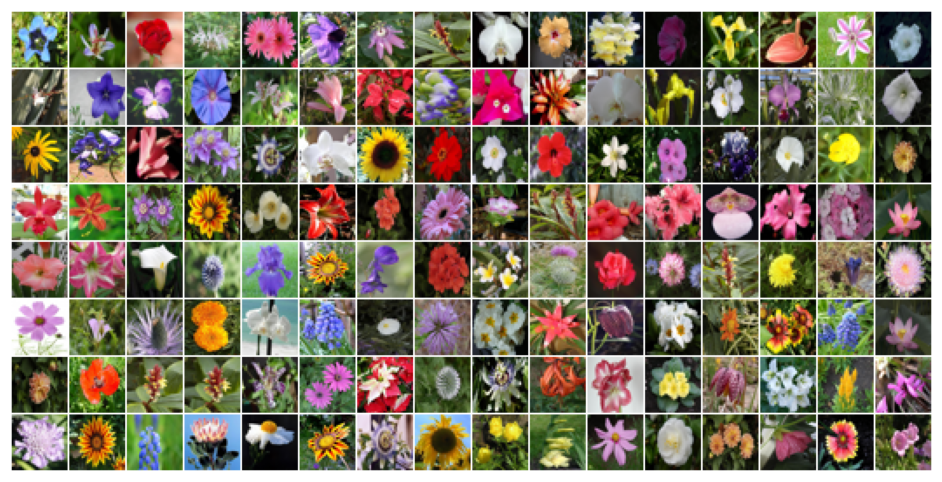

In [166]:
plt.figure(figsize=(12, 6), facecolor='white')

for b_image,_ in dataloader:
    b_image = inverse_transform(b_image).cpu()
    grid_img = make_grid(b_image / 255.0, nrow=16, padding=True, pad_value=1, normalize=True)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis("off")
    break

In [209]:
class ConvVAE(nn.Module):
    def __init__(self, imgChannels=3, featureDim=32*24*24, zDim=256):
        super().__init__()
        self.img_channels = imgChannels
        self.feature_dim = featureDim
        self.z_dim = zDim
        self.enc = Encoder()
        self.dec = Decoder(256,32*24*24)
        
    def forward(self,x):
        mu, logVar = self.enc(x)
        e  = torch.randn(x.shape[0],self.z_dim).cuda()
        z = mu + torch.exp(logVar/2)*e

        out = self.dec(z)

        return out, mu, logVar
        

In [218]:
conv_vae = ConvVAE().cuda()

In [219]:
batch_size = 128
learning_rate = 1e-3
num_epochs = 20

In [220]:
dataloader = DataLoader(dataset, batch_size=batch_size, 
                        pin_memory=False, 
                        num_workers=0, 
                        shuffle=True
                           )

In [221]:
optimizer = torch.optim.Adam(conv_vae.parameters(), lr=learning_rate)

In [233]:
for epoch in range(num_epochs):
    for idx, data in enumerate(dataloader, 0):
        imgs, _ = data
        imgs = imgs.cuda()

        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out, mu, logVar = conv_vae(imgs)

        # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
        kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.mse_loss(out, imgs) + kl_divergence

        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch {}: Loss {}'.format(epoch, loss))

Epoch 0: Loss 0.23285821080207825
Epoch 1: Loss 0.24311164021492004
Epoch 2: Loss 0.23698918521404266
Epoch 3: Loss 0.22594976425170898
Epoch 4: Loss 0.2411598414182663
Epoch 5: Loss 0.2404123693704605
Epoch 6: Loss 0.24669499695301056
Epoch 7: Loss 0.24016086757183075
Epoch 8: Loss 0.24627654254436493
Epoch 9: Loss 0.24736760556697845
Epoch 10: Loss 0.23935218155384064
Epoch 11: Loss 0.24913333356380463
Epoch 12: Loss 0.2184937596321106
Epoch 13: Loss 0.25013643503189087
Epoch 14: Loss 0.23925551772117615
Epoch 15: Loss 0.22885513305664062
Epoch 16: Loss 0.2247065007686615
Epoch 17: Loss 0.23925749957561493
Epoch 18: Loss 0.23708967864513397
Epoch 19: Loss 0.2376084178686142


In [223]:
b_image,_ =  next(iter(dataloader))

In [229]:
b_image,_,_ = conv_vae(b_image.cuda())

In [230]:
b_image = inverse_transform(b_image).cpu()

In [231]:
grid_img = make_grid(b_image / 255.0, nrow=16, padding=True, pad_value=1, normalize=True)

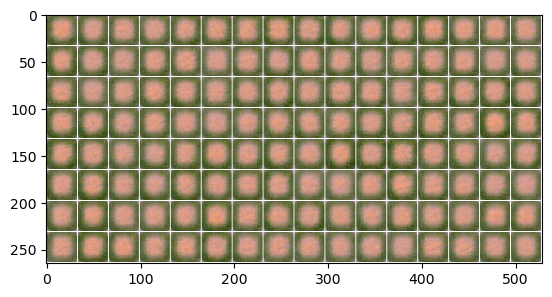

In [232]:
plt.imshow(grid_img.permute(1, 2, 0))